# Cell type differences and effects of interferon stimulation on immune cells

Demonstrating differential expression between cell types and the effect of interferon stimulation within a cell type (CD4 T cells).

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time
#plt.style.use('ggplot')

In [5]:
%matplotlib inline

In [6]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
from sklearn.decomposition import PCA

In [9]:
from sklearn.preprocessing import StandardScaler

In [10]:
# import sys
# sys.path.append('/home/mkim7/Github/scrna-parameter-estimation/simplesc')
# import scme, utils

In [12]:
data_path = '/data/parameter_estimation/interferon_data/20200412/'
fig_path = '/home/ssm-user/Github/scrna-parameter-estimation/figures/fig3/'

### Perform some basic filtering

In [14]:
adata = sc.read(data_path + 'interferon.h5ad')
adata = adata[(adata.obs.multiplets == 'singlet') & (adata.obs.cell != 'nan'), :].copy()

In [15]:
adata.obs.cell.value_counts()

CD4 T cells          10389
CD14+ Monocytes      5385 
B cells              2573 
CD8 T cells          2042 
NK cells             1993 
FCGR3A+ Monocytes    1599 
Dendritic cells      432  
Megakaryocytes       260  
Name: cell, dtype: int64

In [16]:
adata.obs['cell_type'] = (adata.obs['cell'].astype(str) + ' - ' + adata.obs['stim'].astype(str)).astype('category')

... storing 'ind' as categorical
... storing 'stim' as categorical
... storing 'cluster' as categorical
... storing 'cell' as categorical
... storing 'multiplets' as categorical


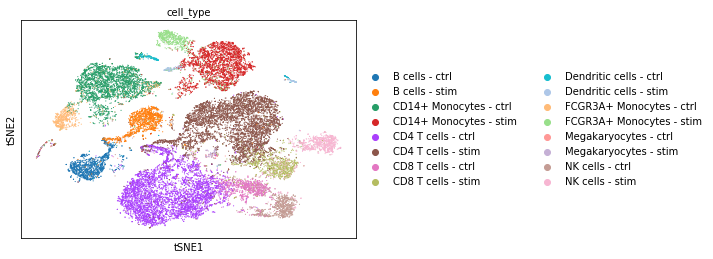

In [17]:
sc.pl.tsne(adata, color='cell_type')

### Cell sizes differences

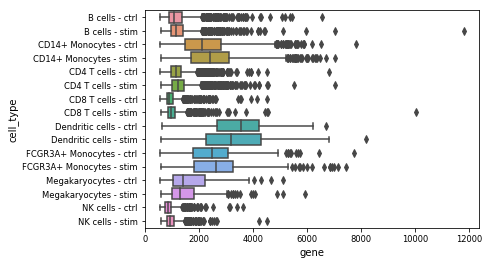

In [18]:
data = adata.obs.copy()
data['gene'] = adata.X.sum(axis=1)
sns.boxplot(x='gene', y='cell_type', data=data)

### Number of unique expression pairs for random pairs of genes

In [48]:
mat = adata.X.tocsc()
num_cells = (mat.toarray() > 0).sum(axis=0)

In [90]:
num_uniques = []
temp = []
num_trial = 100000
for trial in range(num_trial):

    idxs = np.random.choice(mat.shape[1], 2)
    if num_cells[idxs[0]] < 100 or num_cells[idxs[1]] < 100:
        continue
    pair_data = mat[:, idxs].toarray()

    num_unique = []

    for num_cell in np.logspace(2, 4.45, 10):

        subsample = pair_data[np.random.randint(0, mat.shape[0], size=int(num_cell)),]
        num_unique.append(np.unique(subsample).shape[0])

        del subsample
    num_uniques.append(num_unique)


In [94]:
np.percentile([i[-1] for i in num_uniques], 90)

14.0

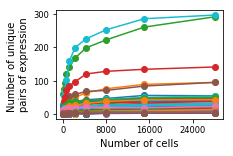

In [85]:
fig = plt.figure(figsize=(3, 2))
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(8000))
plt.xlabel('Number of cells')
plt.ylabel('Number of unique \npairs of expression')
for trial in range(len(num_uniques)):
    plt.plot(list(np.logspace(2, 4.45, 10)), num_uniques[trial], '-o')
plt.savefig(fig_path + 'ifn_unique_pairs.pdf', bbox_inches='tight')


### Number of nonzero entries as a function of number of cells

In [80]:
mat = adata.X#.toarray()

In [81]:
num_unique = []
for num_cell in np.logspace(2, 4.45, 10):
    print(num_cell)
    
    subsample = mat[np.random.randint(0, mat.shape[0], size=int(num_cell)), ].toarray()
    subsample_nonzero = subsample[subsample != 0]
    num_unique.append(np.unique(subsample_nonzero).shape[0]+1)
    
    del subsample
    del subsample_nonzero

100.0
187.16395863694845
350.3034741265335
655.6418494179792
1227.1252398511904
2296.736176338636
4298.662347082281
8045.546617235157
15058.363542798415
28183.82931264455


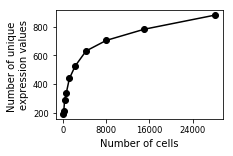

In [83]:
fig = plt.figure(figsize=(3, 2))
plt.plot(list(np.logspace(2, 4.45, 10)), num_unique, '-o', color='k')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(8000))
plt.xlabel('Number of cells')
plt.ylabel('Number of unique \nexpression values')
plt.savefig(fig_path + 'all_ifn_unique_vals.pdf', bbox_inches='tight')
